In [1]:
from nltk import *
#from nltk.corpus import *
from nltk.corpus import stopwords 
from nltk.corpus import PlaintextCorpusReader
from nltk.stem.porter import *
import re
import errno
import pandas as pd
import numpy as np
import nltk as nltk 

In [3]:
#setup dir for Yarn sample data

inputDir = 'C:\\Users\\David\\Google Drive\\CSC478Proj\\code to fetch data + fetched CSVs\\'
outputDir = inputDir
#inputfile = 'comments_single_column.csv'
inputfile = 'comments_with_yarn_ids.csv'     #multi line comments per Yarn
processLimit = 10000

In [4]:
#col_names = ['comment']
yarntxts = pd.read_csv(inputDir+inputfile, sep=',', header = 0 , names=['yarnId', 'comment']) 
#np.set_printoptions(suppress=True, precision=3, linewidth=120)

print yarntxts.dtypes
print 'size of yarn comments ', yarntxts.shape

yarnId      int64
comment    object
dtype: object
size of yarn comments  (33752, 2)


In [5]:
np.set_printoptions(precision=4, linewidth=120, suppress=True)
yarntxts[0:4]

yarnId                                            comment
0   97217                        Where can I find this yarn?
1   97217  I just bought some at Hill Country Weavers in ...
2   73463  How do people purchase your yarn? Often there ...
3   73463  You can purchase my yarn on myEtsysite. I’ll a...

#### Create Custom Stop list using word freq analysis from rounds of testing

In [6]:
#custom yarn stops by Cara
%cd C:/Users/David/Google Drive/CSC478Proj/cara clustering
from cluster_helper_3 import uni_stops
#import cluster_helper_3 as yarn

C:\Users\David\Google Drive\CSC478Proj\cara clustering


In [7]:
# Latest Stops for Unigrams by Cara
print uni_stops

set([u'all', u'go', u'to', u'under', u'far', u'yourselves', u'tri', u't?', u'did', u'havent', u'further', u'even', u'what', u'weren', u'that?', u'above', u'mustn', u'ever', u'hasn', u'440', u'here', u'shouldn', u'109', u'hers', u'103', u'100', u'101', u'sinc', u'104', u'105', u'39', u'38', u'here?', u'33', u'32', u'30', u'37', u'36', u'35', u'34', u'love', u'yourself', u'use', u'from', u'would', u'0', u'two', u'next', u'few', u'6', u'themselves', u'until', u'more', u'notic', u'99', u'98', u'91', u'90', u'93', u'92', u'95', u'94', u'97', u'96', u'me', u'549', u'ma', u'this', u'work', u'can', u'theirs', u'didnt', u'beautiful', u'want', u'230', u'anoth', u'1', u'how', u'anyon', u'needl', u'needn', u'haven', u'after', u'beauti', u'such', u'a', u'so', u'1000', u'over', u'isnt', u'through', u'136', u'hell', u'still', u'its', u'before', u'24', u'25', u'26', u'27', u'20', u'21', u'22', u'23', u'll', u'28', u'29', u'feel', u'400', u'2015', u'ours', u'2011', u'2010', u'2013', u'2012', u'then', u

In [8]:
%cd C:/Users/David/Google Drive/CSC478Proj/nltk_test1/stopwords
yarnstop3 = pd.read_csv('stop_list3_numbers.txt', sep=',', header = None , names=['stopwords']) 
yarnstops3 = set(yarnstop3.stopwords)
yarnstop3[0:4]

C:\Users\David\Google Drive\CSC478Proj\nltk_test1\stopwords


stopwords
0       ﻿hi
1     hello
2        oh
3     color

In [9]:
print 'len of custom number stops', len(yarnstops3)
print 'len of stops', len(uni_stops)
stops = uni_stops.union(yarnstops3)
print 'len of updated stops', len(stops)

len of custom number stops 585
len of stops 393
len of updated stops 839


#### Prepare to clean Yarn Texts - Round 1 on 33K rows of multiple Comments per Yarn ID.  Custom function below 'text_to_words' for cleaning 1 row of text and removes unwanted chars, converts all words to lowercase, removes stop words and applies stemming

In [10]:
## Text to Words func from Kaggle example word 2 vec
def text_to_words(raw_text, stoptype='custom', stem='snow' ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw review), and  # the output is a single string (a preprocessed review)
    
    from nltk.corpus import stopwords 
    from nltk.stem import PorterStemmer # import Porter stemmer
    from nltk.stem.lancaster import LancasterStemmer
    from nltk.stem import SnowballStemmer
    Pst = PorterStemmer()   # create obj of the PorterStemmer
    Lst = LancasterStemmer() # create obj of LancasterStemmer
    Snst = SnowballStemmer("english")    #create obj of Snowball Stemmer
    from nltk.stem import WordNetLemmatizer
    wnlem = WordNetLemmatizer()

    # 1. Remove HTML
    #review_text = BeautifulSoup(raw_review).get_text() 
    review_text = raw_text
    #
    # 2. Remove non-letters but keep ? and ! and treat as a word
    letters_only = re.sub("[^a-zA-Z0-9]", " ", review_text) 
    #print letters_only
    #clean_line = re.sub("[^a-zA-Z0-9\?\!]", " ", line)           #Keep ?s and !s and treat as potential words
    
    # 2A - keep some punctuation like , . ' "
    #letters_only = re.sub("[^a-zA-Z0-9\,\.\'\"\?\(\)\!\&\$\#\@\+\-\=\_\:\;\*\/\%]", " ", review_text)
    
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                         
    #print words
    #
    # 4. In Python, searching a set is much faster than searching  a list, so convert the stop words to a set
    # setting up Stop words is invoked before this func to save time as this func processes text row by row
    #stops = set(stopwords.words("english"))         
    #yarnstops1 = set(yarnstop1.stopwords)     #unigrams
    #yarnstops2 = set(yarnstop2.stopwords)     #bi grams
    #Allstops = stops.union(yarnstops1)   #only apply custom yarn stops to Bi-grams/Tri-grams?
    #Bistops = stops.union(yarnstops2)
    # 
    # 5. Remove stop words
    if  stoptype == 'unigram':
        meaningful_words = [w for w in words if not w in Allstops]     #only for Unigrams
    elif stoptype == 'bigram':
        meaningful_words = [w for w in words if not w in Bistops]      #only for Bi grams
    else:
        meaningful_words = [w for w in words if not w in stops]         #Custom stop words byCara
        #print 'apply Cara stop lists', words
        #print 'meaninful_words after Stop List', meaningful_words
    
      
    #5C - Stemming - Optional
    if stem == 'no':
        #print 'pass ', meaningful_words
        pass             #don't perform stemming or lemming
    #elif stem == 'lem':
     #   meaningful_words = [wnlem.lemmatize(word) for word in  meaningful_words]   #lemmatizer instead of stemming
        #print 'lemming', meaningful_words
    elif stem == 'snow':
        meaningful_words = [Snst.stem(w) if w != 'worsted' else 'worsted' for w in meaningful_words]   # snow stemmer  
        #meaningful_words = ['split' if w in ['split', 'splitt', 'splitti', 'spliti', 'splitt', 'splitty', 'splitabl', 'splittabl' ] else w for w in meaningful_words ]    #merge versions of split
        #meaningful_words = ['fuzz' if w in ['fuzz', 'fuzzi',  'fuzzzi', 'fuzzier'] else w for w in meaningful_words ]     #merge versions of fuzz, fuzzi
        #print 'snowstemmer used' 
    else:
        meaningful_words = [Pst.stem(word) for word in  meaningful_words]               #Porter stemmer reduces # of terms
        #print 'stem', meaningful_words
    
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ), meaningful_words )   


In [11]:
#testing text cleaning and tokenization func above "text_to_words" using 'worsted''
txt = 'sample no baby worsted, worsts, worsting, splitting, splittabl, splitti, fuzzy, fuzzzi, fuzzi '
words, clList = text_to_words( txt , 'std', 'snow' )
#words, clList = text_to_words( txt , 'std', 'no' )
print words, clList

sampl babi worsted worst worst split splittabl splitti fuzzi fuzzzi fuzzi [u'sampl', u'babi', 'worsted', u'worst', u'worst', u'split', u'splittabl', u'splitti', u'fuzzi', u'fuzzzi', u'fuzzi']


#### Custom Func to pass in a dataframe of rows of yarn comments to clean and return cleaned up words and word freq dict

In [12]:
##-- Func to Process Yarn Comments Text panda DF to get word freq for Unigrams 
# Get the number of reviews based on the dataframe column size
def clean_yarn_txts(yarntxt, stoptype = 'custom', stemtype='lem'):
    #expect pandas df with a  column called "comment" that holds each line of text 
    num_rows = yarntxt["comment"].size

    # Initialize an empty list to hold the clean texts
    clean_texts = []
    cleanedwordList = []
    wordFreq = dict()
    i = 0
    # Loop over each review; create an index i that goes from 0 to the length of the review list 

    #for i in xrange( 0, num_rows ):
    for txtline in yarntxt.comment:    
        cleanedwords, cleanedwordList = ( text_to_words( txtline, stoptype, stemtype ) )
        clean_texts.append(cleanedwords)
        #clean_texts.append( text_to_words( txtcorpusdf["TextBody"][i] ) )

        if ( i% 5000 == 0 ):  print 'processing row ', i 

        for word in cleanedwordList:   #compile word dict frequency 
            #print '|' + word + '|' 
            if wordFreq.has_key(word): 
                wordFreq[word] += 1 
            else: 
                wordFreq[word] = 1
        
        i +=1

    print 'cleaning yarn comments is finished!'
    return clean_texts, wordFreq

In [13]:
#clean Yarn Text for Unigrams ;  #pass in dataframe and specify stop list type and stem type
clean_texts, R1_wordfreq_david  = clean_yarn_txts(yarntxts, 'custom',  'snow')

processing row  0
processing row  5000
processing row  10000
processing row  15000
processing row  20000
processing row  25000
processing row  30000
cleaning yarn comments is finished!


In [14]:
print 'len of clean_texts', len(clean_texts)
print 'len of wordFreq', len(R1_wordfreq_david )

len of clean_texts 33752
len of wordFreq 20737


In [15]:
## Cara's function 
def process_comments(yarntxts):  #where yarntxts is a df with 2 columns, "comments" and "yarnId"
    from collections import Counter
    from nltk.stem import SnowballStemmer
    import re
    Snst = SnowballStemmer("english")    #create obj of Snowball Stemmer
    clean_comment_lists = [text_to_snow_stem(comment) for comment in yarntxts["comment"]] 	#get each comment as a clean list
    overall_word_freq = dict(Counter([word for comment in clean_comment_lists for word in comment]))   #get word frequency dict
    clean_comment_strings = [" ".join(comment) for comment in clean_comment_lists]  	#get each comment as a clean string
    yarntxts["word_count"] = [len(text) for text in clean_comment_lists]  #add column of word count per cleaned comment to yarntxts 
    
    return overall_word_freq, clean_comment_strings


In [16]:
#R1_wordfreq_uni, clean_texts_cara  = process_comments(yarntxts)

In [17]:
##Produce Word Count matrix of Unigrams with Allstops - Choosing Min Doc Frequency to suit (min_df = x)
from sklearn.feature_extraction.text import CountVectorizer
# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.  
#count_vect = CountVectorizer(analyzer = 'word', tokenizer = None, stop_words = stops, min_df=3, max_features = 10000)
#count_vect = CountVectorizer(analyzer = 'word', tokenizer = None, min_df=10, max_features = 10000)
count_vect  = CountVectorizer(analyzer = 'word', stop_words=stops, ngram_range=(1, 1), token_pattern=r'\b\w+\b', min_df=10)

#count_vect = CountVectorizer()
# fit_transform() does two functions: First, it fits the model,  and learns the vocabulary; second, it transforms our training data into feature vectors.
# The input to fit_transform should be a list of  strings.
X_train_counts = count_vect.fit_transform(clean_texts)
print 'X_train_counts is complete !'

X_train_counts is complete !


In [18]:
print X_train_counts.shape          #each doc is a row with word terms as columns
print 'Count Vect shape after Unigrams with Lemming'
X_train_counts[0:10]
#X_train_counts.sum(axis=1)

(33752, 3418)
Count Vect shape after Unigrams with Lemming


<10x3418 sparse matrix of type '<type 'numpy.int64'>'
	with 67 stored elements in Compressed Sparse Row format>

In [19]:
## Create 2nd Unigram Word Freq after Count Vectorizer with Min_DocFq applied
train_data_features =X_train_counts.toarray()
# Sum up the counts of each vocabulary word 
dist = np.sum(train_data_features, axis=0)
vocab = count_vect.get_feature_names()

# For each, print the vocabulary word and the number of times it   appears in the training set
wordFreq_minDF = dict()
for tag, count in zip(vocab, dist):
    #print count, tag
    wordFreq_minDF[tag] = count
    
print 'Uni-gram wordFreq with Min_DF= 10 is complete! '

Uni-gram wordFreq with Min_DF= 10 is complete! 


In [20]:
##-  Function to write out Word Freq Dict to file
import csv
import os
currentPath = os.getcwd()
print currentPath

def writeoutdict(dir_name, filename, dictionary):
    csv_file = dir_name + filename

    openfile = open(csv_file, 'wb')
    writer = csv.writer(openfile)
    for key, value in dictionary.items():
        writer.writerow([key, value])

    openfile.close()
    print 'csv_file is written out', csv_file

C:\Users\David\Google Drive\CSC478Proj\nltk_test1\stopwords


In [73]:
inputDir = 'C:\\Users\\David\\Google Drive\\CSC478Proj\\nltk_test1\\wordfreq_custstop1\\'
fname = 'Uni_gram_wordFreq-min_DF10_June1.csv'
#dump out bi-gram Word Freq dict to file
writeoutdict(inputDir, fname, wordFreq_minDF )

csv_file is written out C:\Users\David\Google Drive\CSC478Proj\nltk_test1\wordfreq_custstop1\Uni_gram_wordFreq-min_DF10_June1.csv


In [74]:
inputDir = 'C:\\Users\\David\\Google Drive\\CSC478Proj\\nltk_test1\\wordfreq_custstop1\\'
fname = 'Orig_wordFreq-afterStopWords-David_June1.csv'
#dump out bi-gram Word Freq dict to file
writeoutdict(inputDir, fname, R1_wordfreq_david )

csv_file is written out C:\Users\David\Google Drive\CSC478Proj\nltk_test1\wordfreq_custstop1\Orig_wordFreq-afterStopWords-David_June1.csv


#### Create tfdf array for clustering 

In [21]:
#or goto tf_idf in 1 step using fit_transform (http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_tfidf.shape

(33752, 3418)

#### Manual Clustering tests - from exploratory testing, 1st round clustering on K=8 looked the best by judging cluster sizes as K changed and looking at various Silhouette plots 

In [22]:
from sklearn.cluster import KMeans 
print 'unigram tfidf ', X_tfidf.shape

unigram tfidf  (33752, 3418)


In [23]:
from sklearn.cluster import KMeans 
##--> Try 8 Clusters now
kmeans = KMeans(n_clusters=8, max_iter=500, verbose=0, n_jobs = -2) # all CPUs - 1 to speed up convergence
#kmeans = KMeans(n_clusters=5, max_iter=500, verbose=1)             # 
kmeans.fit(X_tfidf)

KMeans(copy_x=True, init='k-means++', max_iter=500, n_clusters=8, n_init=10,
    n_jobs=-2, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [24]:
km_clusters = kmeans.predict(X_tfidf)
print 'km clusters is fitted and predicted'

km clusters is fitted and predicted


In [25]:
print km_clusters.shape
cluster_tab = pd.crosstab(index=km_clusters,  # Make a crosstab
                              columns="count")      # Name the count column

print 'KMeans 8 Cluster Results', '\n', cluster_tab
#kmeans.cluster_centers_

(33752L,)
KMeans 8 Cluster Results 
col_0  count
row_0       
0       1874
1       2377
2       1708
3       1318
4       1761
5       1709
6       1479
7      21526


#### Merge 1st Round cluster results with orig data frame as we need to remove the Largest Cluster's rows as those are comments that are not useful and are just noise.  This is required before Round 2 re-clustering

In [30]:
## Only use when Re-Runing clustering in Round 1
#yarntxts.drop('km_8clusters', axis=1, inplace=True)

In [27]:
## merge cluster results with yarntxt pandas df
yarntxts['km_8clusters'] = km_clusters
yarntxts[0:5]

yarnId                                            comment  km_8clusters
0   97217                        Where can I find this yarn?             7
1   97217  I just bought some at Hill Country Weavers in ...             7
2   73463  How do people purchase your yarn? Often there ...             7
3   73463  You can purchase my yarn on myEtsysite. I’ll a...             7
4   73463  Omg… How i love, love, love your yarn. ♥ Wish ...             7

In [31]:
#Updated rejected cluster after each run 
rejected = [7]
yarnrejects = yarntxts[ yarntxts.km_8clusters.isin(rejected) ]
#outDir = 'C:\\Users\\David\\Google Drive\\CSC478Proj\\nltk_test1\\kmclusters\\'
#fname = 'KM8RejectedClusters_Round1June1.csv'
#yarnrejects.to_csv(outDir+fname)

In [32]:
#remove rows of largest cluster, keep remaining clusters
keep = [0, 1, 2, 3, 4, 5, 6]               #UPDATE after each clustering run
yarnlite = yarntxts[ yarntxts.km_8clusters.isin(keep) ]
print yarnlite.shape
yarnlite[0:5]

(12226, 3)


yarnId                                            comment  km_8clusters
9    81403  This yarn is absolutely beautiful. Very nice t...             2
10   81403  I’m disappointed with this yarn. It was expens...             1
15   13734  Yarn does pill quite a bit if worn. Nice color...             5
21   72422  This is not a Super-Bulky yarn. Bernat states ...             3
26   72422  Feels amazing- like wrapping up in a fluffy cl...             1

In [91]:
#outDir = 'C:\\Users\\David\\Google Drive\\CSC478Proj\\nltk_test1\\kmclusters\\'
#fname = 'KM8ClustersResults_Round1June1.csv'
#yarntxts.to_csv(outDir+fname)

#### Round 2 clustering using reduced dataset 'yarnlite' with only 12k rows now

In [33]:
#clean smaller dataset after intial clustering-  Phase 2 of clustering  #pass in dataframe and specify stop list type and stem type
clean_txt2, R2_wordfreq_david  = clean_yarn_txts(yarnlite, 'custom',  'snow')

processing row  0
processing row  5000
processing row  10000
cleaning yarn comments is finished!


In [93]:
inputDir = 'C:\\Users\\David\\Google Drive\\CSC478Proj\\nltk_test1\\wordfreq_custstop1\\'
fname = 'Round2_wordFreq-afterjunkClusterRemoved-June1.csv'
#dump out latest Word Freq dict to file
writeoutdict(inputDir, fname, R2_wordfreq_david )
len(clean_txt2)

csv_file is written out C:\Users\David\Google Drive\CSC478Proj\nltk_test1\wordfreq_custstop1\Round2_wordFreq-afterjunkClusterRemoved-June1.csv


13534

In [34]:
#compute tfidf again on reduce dataset
from sklearn.feature_extraction.text import TfidfVectorizer
R2_tfidf_vect = TfidfVectorizer(lowercase=True, analyzer='word', stop_words = stops, token_pattern=r'\b\w+\b', 
                               ngram_range=(1,1), min_df=10, max_features=2000)

#fit vectorizer
R2_tfidf_uni = R2_tfidf_vect.fit_transform(clean_txt2)
print '2nd Round Clustering now has ', R2_tfidf_uni.shape[1], ' features'
R2_tfidf_uni.shape

2nd Round Clustering now has  1787  features


(12226, 1787)

#### Sample test on K = 8 before iterative testing with Silhouette plots

In [35]:
kmeans = KMeans(n_clusters=8, max_iter=500, verbose=0, n_jobs = -2) # all CPUs - 1 to speed up convergence
kmeans.fit(R2_tfidf_uni)
km_clusters = kmeans.predict(R2_tfidf_uni)
print 'Round 2 - 8 Clusters KM'
print pd.crosstab(index=km_clusters, columns="count")

Round 2 - 8 Clusters KM
col_0  count
row_0       
0       1657
1       1745
2        688
3       1749
4       1834
5        665
6       2420
7       1468


In [38]:
#yarnlite.drop('R2_clusters', axis=1, inplace=True)   ##- only used if need to drop column when re-running clusters
yarnlite[0:5]

yarnId                                            comment  km_8clusters  \
9    81403  This yarn is absolutely beautiful. Very nice t...             2   
10   81403  I’m disappointed with this yarn. It was expens...             1   
15   13734  Yarn does pill quite a bit if worn. Nice color...             5   
21   72422  This is not a Super-Bulky yarn. Bernat states ...             3   
26   72422  Feels amazing- like wrapping up in a fluffy cl...             1   

    Round2_clusters  
9                 0  
10                6  
15                1  
21                2  
26                6

In [37]:
## merge Round 2- 8 cluster results with yarnlite pandas df
print yarnlite.shape
yarnlite['Round2_clusters'] = km_clusters
#outDir = 'C:\\Users\\David\\Google Drive\\CSC478Proj\\nltk_test1\\kmclusters\\'
#fname = 'km8ClustersRound2_June1.csv'
#yarnlite.to_csv(outDir+fname)

(12226, 3)


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [29]:
import time
from sklearn.metrics import silhouette_samples, silhouette_score
# The silhouette_score gives the average value for all the samples.  # This gives a perspective into the density and separation of the formed clusters

print 'Start time of Silhouette Avg clusters Unigram-Round 2'
print (time.time(), time.clock())
silhou_avg = silhouette_score(R2_tfidf_uni, km_clusters)            ## Do NOT Run unless Matrix small enough-  takes way too long for large matrix
print 'End Time of Sihouette Avg'
print (time.time(), time.clock())

Start time of Silhouette Avg clusters Unigram-Round 2
(1464622218.132, 134.92092053179516)
End Time of Sihouette Avg
(1464622308.182, 224.98116957983942)


In [39]:
#try to plot silhouette
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_silhouette(cluster_labels, sample_silhouette_values, clusterer, n_clusters, tfidf, silhouette_avg):
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    
       
    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to  # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]

        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(i) / n_clusters)

        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    chartitle = "The silhouette plot for " + str(n_clusters) + " clusters and Avg Silhouette Score"
    ax1.set_title(chartitle)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhoutte score of all the values
    #silhouette_avg = silhouette_score(tfidf, km_clusters)      #pass in silhouette avg from outside 
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.set_xticks([-0.03, 0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16])
    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
        
    plt.show()

#### Iterate thru range of K values and calculate Silhouette Avg, Davies Bouldin Index and plot Silhouette plots

In [40]:
#custom cluster indices code : https://github.com/jqmviegas/jqm_cvi
%cd C:/Users/David/Google Drive/CSC478Proj/nltk_test1
import jqmcvi_base as jqmcvi

C:\Users\David\Google Drive\CSC478Proj\nltk_test1


Cluster Sizes Results of K =  3  iteration clustering
col_0  count
row_0       
0       1362
1       9700
2       2947

Silhouette Avg Score for Cluster K =  3  is :  0.0108205460865

Davies Bouldin Score for Cluster K =  3  is :  8.05122042069



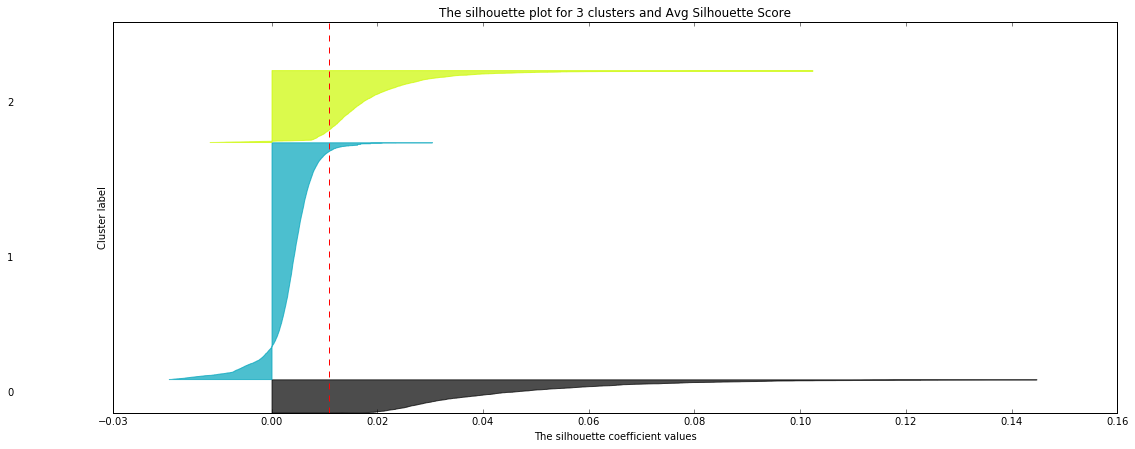

Cluster Sizes Results of K =  4  iteration clustering
col_0  count
row_0       
0       2867
1       1353
2       2179
3       7610

Silhouette Avg Score for Cluster K =  4  is :  0.0126004233504

Davies Bouldin Score for Cluster K =  4  is :  8.07806232257



Cluster Sizes Results of K =  5  iteration clustering
col_0  count
row_0       
0       5412
1       2999
2       2184
3       1324
4       2090

Silhouette Avg Score for Cluster K =  5  is :  0.0135042548738

Davies Bouldin Score for Cluster K =  5  is :  8.28582659482



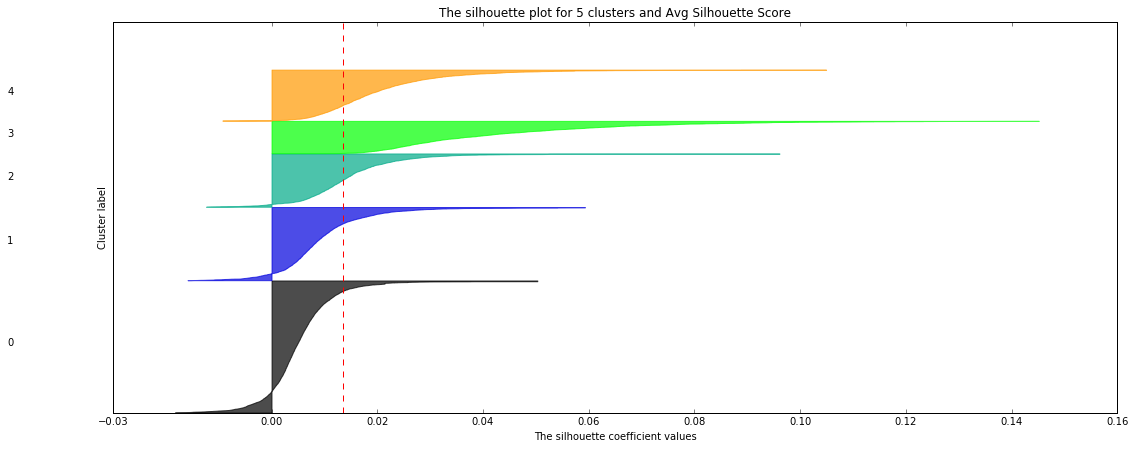

Cluster Sizes Results of K =  6  iteration clustering
col_0  count
row_0       
0       1987
1       1476
2       4767
3       1322
4       2661
5       1796

Silhouette Avg Score for Cluster K =  6  is :  0.01664251389

Davies Bouldin Score for Cluster K =  6  is :  7.6584246993



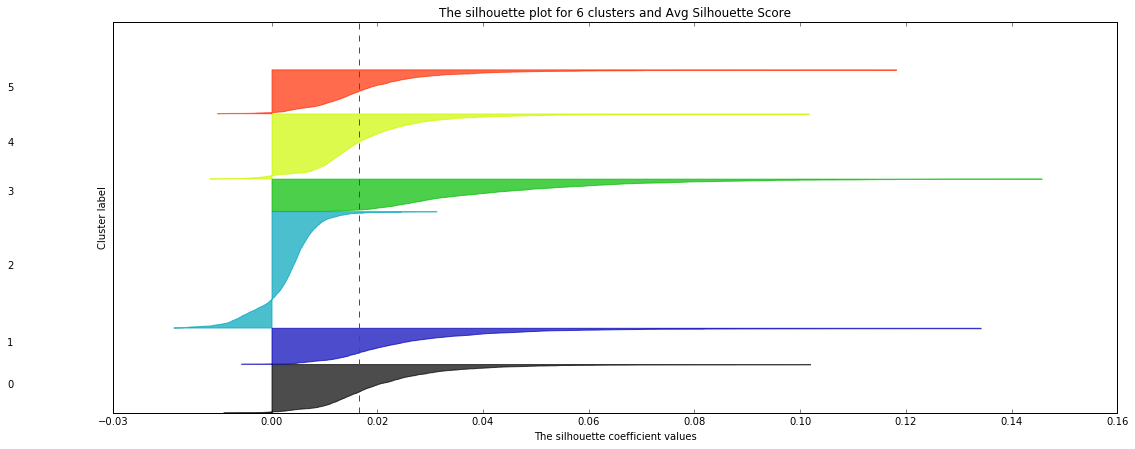

Cluster Sizes Results of K =  7  iteration clustering
col_0  count
row_0       
0       1295
1       3139
2       2644
3       1972
4       1770
5       1764
6       1425

Silhouette Avg Score for Cluster K =  7  is :  0.0183574197999

Davies Bouldin Score for Cluster K =  7  is :  7.15312455651



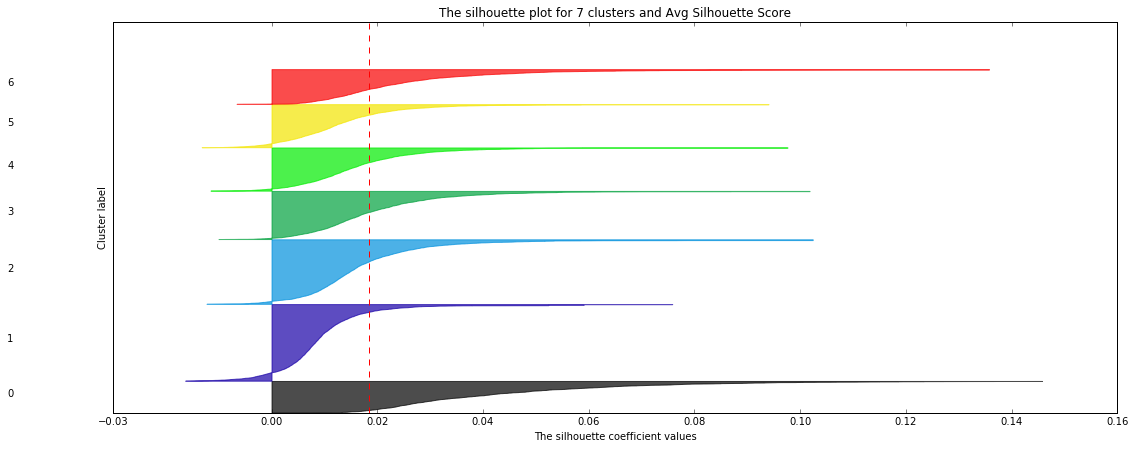

Cluster Sizes Results of K =  8  iteration clustering
col_0  count
row_0       
0       1788
1       2520
2       1918
3       1408
4       1732
5       1275
6       1678
7       1690

Silhouette Avg Score for Cluster K =  8  is :  0.0195791489077

Davies Bouldin Score for Cluster K =  8  is :  6.69803452698



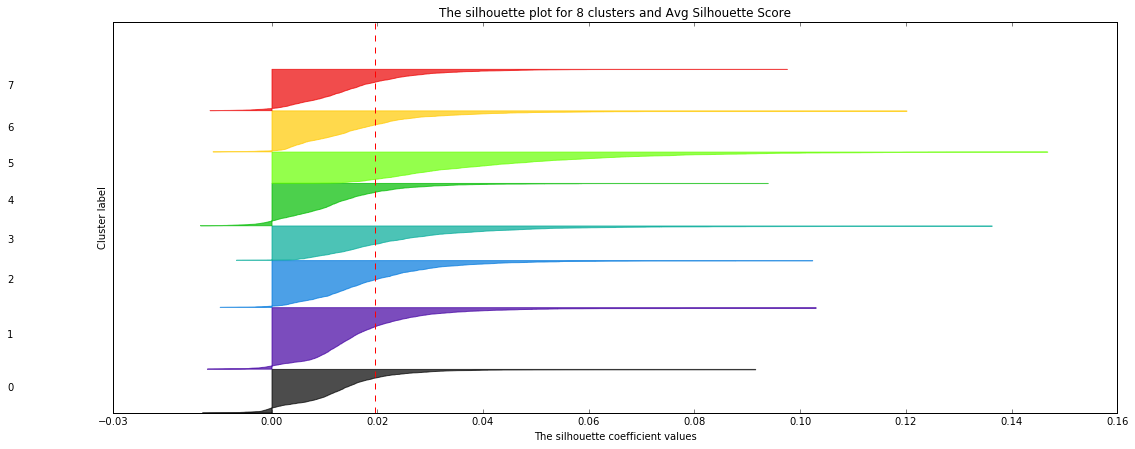

Cluster Sizes Results of K =  9  iteration clustering
col_0  count
row_0       
0       1718
1       1270
2       1364
3        751
4       1691
5       1470
6       1611
7       1670
8       2464

Silhouette Avg Score for Cluster K =  9  is :  0.0183087677245

Davies Bouldin Score for Cluster K =  9  is :  6.67404294021



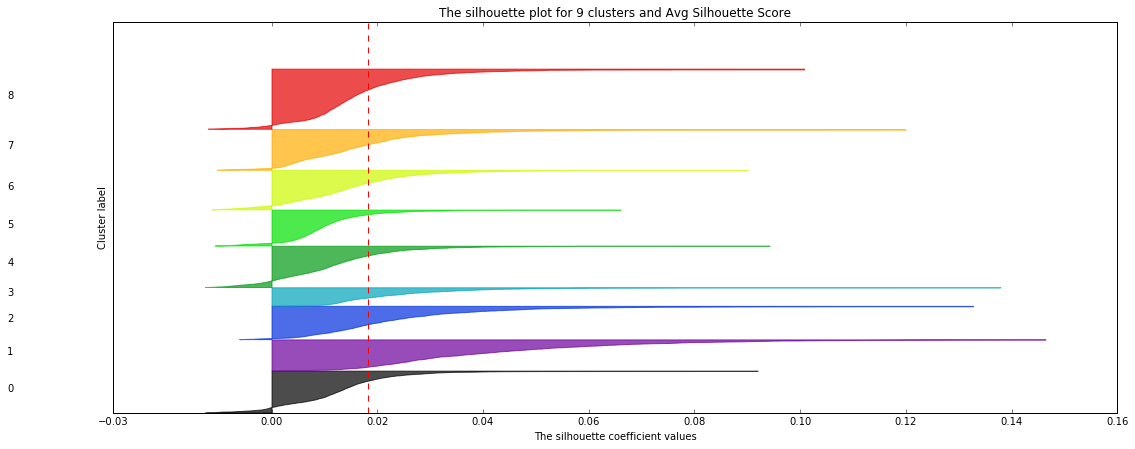

Cluster Sizes Results of K =  10  iteration clustering
col_0  count
row_0       
0       1618
1       1239
2       1495
3       2421
4        411
5       1849
6       1369
7       1656
8        513
9       1438

Silhouette Avg Score for Cluster K =  10  is :  0.0190299042121

Davies Bouldin Score for Cluster K =  10  is :  6.45449224864



In [36]:
#Round 2 Iterate over K values to cluster and calculate Silhouette and plot each K
KValues = []
SilhouAvg = []   #store silhouette scores
DBidx = []          #store Dsavies Bouldin index

for K in range(3, 11):
    kmeans = KMeans(n_clusters=K, max_iter=500, verbose=0, n_jobs = -2) # all CPUs - 1 to speed up convergence
    kmeans.fit(R2_tfidf_uni)
    km_clusters = kmeans.predict(R2_tfidf_uni)
    print 'Cluster Sizes Results of K = ', K, ' iteration clustering'
    print pd.crosstab(index=km_clusters, columns="count")
    print 
    #print 'Start time of Silhouette', K, '  clusters Unigram-Round 2'
    #print (time.time(), time.clock())
    # Compute the silhouette scores for each sample
    silhou_val_uni = silhouette_samples(R2_tfidf_uni , km_clusters)  
    
    SilhouAvg_km =silhouette_score(R2_tfidf_uni, km_clusters)
    print 'Silhouette Avg Score for Cluster K = ', K, ' is : ', SilhouAvg_km
    print
    
    #prepare for Davies Bouldin calculation
    R2_TFidf_Dense = R2_tfidf_uni.todense()
    
    c_klist = []
    for i in range (K):
        #create appropriate length LIST of Clusters for each K iteration to calculate DB Index
        if i == 0: c_klist =  [ R2_TFidf_Dense[ np.where(km_clusters == i) ] ]
        else: c_klist.append( R2_TFidf_Dense[ np.where(km_clusters == i) ] )

    # Compute the DB index scores for each kmeans round
    DBidx_kmR2 = jqmcvi.davisbouldin(c_klist , kmeans.cluster_centers_)  
    print 'Davies Bouldin Score for Cluster K = ', K, ' is : ', DBidx_kmR2
    print

    KValues.append(K)
    SilhouAvg.append(SilhouAvg_km)
    DBidx.append(DBidx_kmR2)
    
    #print 'End time of Silhouette ', K, '  clusters Unigram Round 2 computation'
    #print (time.time(), time.clock())

    %matplotlib inline
    plot_silhouette(km_clusters, silhou_val_uni, kmeans, K, R2_tfidf_uni, SilhouAvg_km)

In [ ]:
silhou_avg = silhouette_score(R2_tfidf_uni, km_clusters)

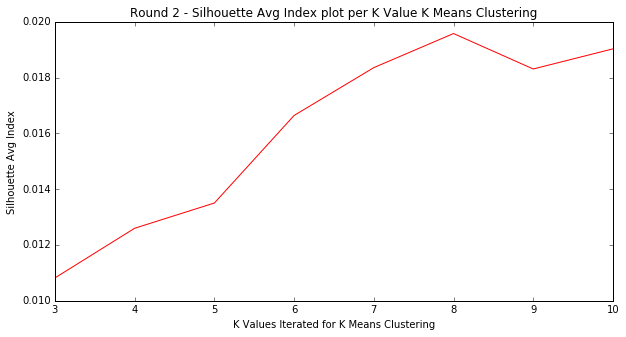

In [37]:
import pylab as pl
pl.figure()
plt.figure(figsize=(10,5))    
pl.xlabel("K Values Iterated for K Means Clustering")
pl.ylabel("Silhouette Avg Index")
#pl.plot(percentiles, ErrMean, 'b-')     #Blue for Non-Cross Validation Simply increase % features          
pl.plot(KValues, SilhouAvg, 'r-')    #Red for Cross Validation
plt.title('Round 2 - Silhouette Avg Index plot per K Value K Means Clustering')


In [33]:
len(KValues)

8

In [38]:
print 'Silhouette Scores calculated per K' 
SHpd = pd.DataFrame(SilhouAvg, columns=['Avg Silhouette Scores per K'],  index = KValues)
SHpd

Silhouette Scores calculated per K


Avg Silhouette Scores per K
3                      0.010821
4                      0.012600
5                      0.013504
6                      0.016643
7                      0.018357
8                      0.019579
9                      0.018309
10                     0.019030

#### Try Davies Bouldin Index via custom code from Git Hub

In [99]:
#custom cluster indices code : https://github.com/jqmviegas/jqm_cvi
%cd C:/Users/David/Google Drive/CSC478Proj/nltk_test1
import jqmcvi_base as jqmcvi

C:\Users\David\Google Drive\CSC478Proj\nltk_test1


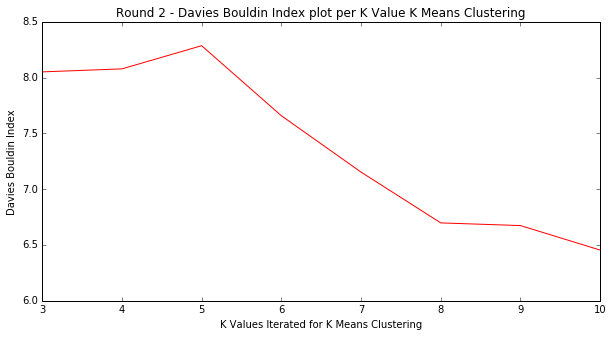

In [39]:
import pylab as pl
pl.figure()
plt.figure(figsize=(10,5))    
pl.xlabel("K Values Iterated for K Means Clustering")
pl.ylabel("Davies Bouldin Index")
pl.plot(KValues, DBidx, 'r-')    #Red for
plt.title('Round 2 - Davies Bouldin Index plot per K Value K Means Clustering')

In [40]:
print 'Davies Boulding Scores calculated per K' 
DBpd = pd.DataFrame(DBidx, columns=['Davies Bouldin Scores per K'],  index = KValues)
DBpd

Davies Boulding Scores calculated per K


Davies Bouldin Scores per K
3                      8.051220
4                      8.078062
5                      8.285827
6                      7.658425
7                      7.153125
8                      6.698035
9                      6.674043
10                     6.454492

#### print out Top Terms for 10 Clusters

In [39]:
#import Cara's funcs
%cd C:/Users/David/Google Drive/CSC478Proj/cara clustering
from cluster_helper_3 import top_terms

C:\Users\David\Google Drive\CSC478Proj\cara clustering


In [101]:
K=8
print 'Cluster Sizes Results of K = ', K, ' iteration clustering'
print pd.crosstab(index=km_clusters, columns="count")
print 

 Cluster Sizes Results of K =  8  iteration clustering
col_0  count
row_0       
0       1749
1       1739
2       2620
3       1995
4       2484
5        975
6        689
7       1283



In [43]:
kmeans = KMeans(n_clusters=9, max_iter=500, verbose=0, n_jobs = -2) # all CPUs - 1 to speed up convergence
kmeans.fit(R2_tfidf_uni)
km_clusters = kmeans.predict(R2_tfidf_uni)
print 'Round 2 - 9 Clusters KM'
print pd.crosstab(index=km_clusters, columns="count")
#print out top terms per Round 2 Cluster for 9 clusters
top_terms(R2_tfidf_uni.todense(), km_clusters, R2_tfidf_vect .get_feature_names(), 9, 20)

Round 2 - 9 Clusters KM
col_0  count
row_0       
0       1471
1       2455
2       1263
3       1746
4       1871
5       1384
6        514
7       1705
8       1600

Cluster 1 has 1471 total documents.
The top 20 terms, ranked by the number of this cluster's documents in which they appear, are:
Rank	Term		Pct of Docs w/Term	Term Doc Freq, Cluster 1
1 	block 		0.99 			1456
2 	wet 		0.189 			278
3 	soak 		0.158 			232
4 	sweater 		0.145 			214
5 	finish 		0.139 			205
6 	stitch 		0.129 			190
7 	grow 		0.111 			163
8 	swatch 		0.11 			162
9 	water 		0.11 			162
10 	dri 		0.106 			156
11 	size 		0.106 			156
12 	bleed 		0.101 			148
13 	knot 		0.097 			142
14 	time 		0.094 			138
15 	stretch 		0.092 			136
16 	quit 		0.091 			134
17 	scarf 		0.09 			132
18 	dye 		0.089 			131
19 	soften 		0.084 			124
20 	grew 		0.083 			122

Cluster 2 has 2455 total documents.
The top 20 terms, ranked by the number of this cluster's documents in which they appear, are:
Rank	Term		Pct of Docs w/Term	Ter

In [102]:
#kmeans = KMeans(n_clusters=8, max_iter=500, verbose=0, n_jobs = -2) # all CPUs - 1 to speed up convergence
#kmeans.fit(R2_tfidf_uni)
#km_clusters = kmeans.predict(R2_tfidf_uni)
print 'Round 2 - 8 Clusters KM-June1'
print pd.crosstab(index=km_clusters, columns="count")
#print out top terms per Round 2 Cluster for 8 clusters
top_terms(R2_tfidf_uni.todense(), km_clusters, R2_tfidf_vect .get_feature_names(), 8, 50)

Round 2 - 8 Clusters KM-June1
col_0  count
row_0       
0       1749
1       1739
2       2620
3       1995
4       2484
5        975
6        689
7       1283

Cluster 1 has 1749 total documents.
The top 50 terms, ranked by the number of this cluster's documents in which they appear, are:
Rank	Term		Pct of Docs w/Term	Term Doc Freq, Cluster 1
1 	block 		0.992 			1735
2 	wet 		0.168 			293
3 	shawl 		0.16 			280
4 	soak 		0.156 			273
5 	finish 		0.156 			272
6 	stitch 		0.145 			253
7 	sweater 		0.121 			212
8 	split 		0.117 			204
9 	water 		0.106 			185
10 	time 		0.103 			181
11 	knot 		0.099 			174
12 	lace 		0.098 			172
13 	bleed 		0.098 			172
14 	swatch 		0.097 			169
15 	grow 		0.095 			167
16 	size 		0.093 			162
17 	dri 		0.092 			161
18 	dye 		0.086 			151
19 	scarf 		0.086 			150
20 	quit 		0.085 			149
21 	problem 		0.081 			142
22 	stretch 		0.079 			139
23 	drape 		0.079 			138
24 	back 		0.077 			134
25 	soften 		0.075 			132
26 	hope 		0.075 			132
27 	grew 		0.071 	

In [45]:
kmeans = KMeans(n_clusters=7, max_iter=500, verbose=0, n_jobs = -2) # all CPUs - 1 to speed up convergence
kmeans.fit(R2_tfidf_uni)
km_clusters = kmeans.predict(R2_tfidf_uni)
print 'Round 2 - 7 Clusters KM'
print pd.crosstab(index=km_clusters, columns="count")
#print out top terms per Round 2 Cluster for 8 clusters
top_terms(R2_tfidf_uni.todense(), km_clusters, R2_tfidf_vect .get_feature_names(), 7, 20)

Round 2 - 7 Clusters KM
col_0  count
row_0       
0       1756
1       1940
2       1446
3       3221
4       1301
5       2612
6       1733

Cluster 1 has 1756 total documents.
The top 20 terms, ranked by the number of this cluster's documents in which they appear, are:
Rank	Term		Pct of Docs w/Term	Term Doc Freq, Cluster 1
1 	wool 		0.999 			1754
2 	acryl 		0.099 			174
3 	sweater 		0.096 			169
4 	merino 		0.096 			168
5 	knot 		0.091 			160
6 	time 		0.09 			158
7 	scratchi 		0.089 			157
8 	skin 		0.088 			154
9 	price 		0.085 			150
10 	finish 		0.082 			144
11 	stitch 		0.081 			143
12 	problem 		0.081 			142
13 	blend 		0.08 			141
14 	warm 		0.072 			126
15 	cotton 		0.071 			125
16 	hat 		0.071 			124
17 	itchi 		0.071 			124
18 	pill 		0.065 			115
19 	machin 		0.062 			109
20 	split 		0.06 			105

Cluster 2 has 1940 total documents.
The top 20 terms, ranked by the number of this cluster's documents in which they appear, are:
Rank	Term		Pct of Docs w/Term	Term Doc Freq, Clus

In [46]:
kmeans = KMeans(n_clusters=6, max_iter=500, verbose=0, n_jobs = -2) # all CPUs - 1 to speed up convergence
kmeans.fit(R2_tfidf_uni)
km_clusters = kmeans.predict(R2_tfidf_uni)
print 'Round 2 - 6 Clusters KM'
print pd.crosstab(index=km_clusters, columns="count")
#print out top terms per Round 2 Cluster for 8 clusters
top_terms(R2_tfidf_uni.todense(), km_clusters, R2_tfidf_vect .get_feature_names(), 6, 20)

Round 2 - 6 Clusters KM
col_0  count
row_0       
0       1791
1       2667
2       1324
3       4767
4       1481
5       1979

Cluster 1 has 1791 total documents.
The top 20 terms, ranked by the number of this cluster's documents in which they appear, are:
Rank	Term		Pct of Docs w/Term	Term Doc Freq, Cluster 1
1 	splitti 		1.0 			1791
2 	stitch 		0.173 			310
3 	knot 		0.089 			159
4 	finish 		0.087 			155
5 	cotton 		0.085 			152
6 	problem 		0.083 			149
7 	pli 		0.083 			148
8 	time 		0.078 			139
9 	pretti 		0.078 			139
10 	split 		0.076 			136
11 	crochet 		0.075 			135
12 	quit 		0.075 			134
13 	fabric 		0.071 			127
14 	price 		0.065 			116
15 	frog 		0.06 			107
16 	agre 		0.058 			103
17 	pair 		0.055 			99
18 	twist 		0.053 			95
19 	gorgeous 		0.05 			90
20 	loos 		0.047 			85

Cluster 2 has 2667 total documents.
The top 20 terms, ranked by the number of this cluster's documents in which they appear, are:
Rank	Term		Pct of Docs w/Term	Term Doc Freq, Cluster 2
1 	knot 		1